## **Finetuning** `facebook/bart-base` **on** `bitext/Bitext-customer-support-llm-chatbot-training-dataset` **dataset**

---

Okay, I'm ditching the `facebook/bart-large` model since it's very large and turns out it takes a lot of time to train... 

<div style="text-align: center; margin: 0 auto;">
    <img src="https://i.postimg.cc/kXkRFZzD/Screenshot-12.jpg" alt="Taking wild time">
</div>

In [1]:
# !pip install datasets transformers torch

In [2]:
from transformers import BartForConditionalGeneration, BartTokenizer, Trainer, TrainingArguments

model_name= "facebook/bart-base"

model= BartForConditionalGeneration.from_pretrained(model_name)
tokenizer= BartTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces = True)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("Hugging_face")
secret_value_1 = user_secrets.get_secret("wandb_api_key")

In [4]:
from huggingface_hub import login

login(secret_value_0)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [5]:
from datasets import load_dataset

ds = load_dataset("bitext/Bitext-customer-support-llm-chatbot-training-dataset")

README.md:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

(…)t_Training_Dataset_27K_responses-v11.csv:   0%|          | 0.00/19.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/26872 [00:00<?, ? examples/s]

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})

In [7]:
##@ Train Test Split

train_test_split = ds['train'].train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

print(train_test_split)

DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 21497
    })
    test: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 5375
    })
})


In [8]:
import pandas as pd

df = pd.DataFrame(ds['train'])

In [9]:
df['instruction'].unique()

array(['question about cancelling order {{Order Number}}',
       'i have a question about cancelling oorder {{Order Number}}',
       'i need help cancelling puchase {{Order Number}}', ...,
       'how to see if there is anything wrong with my restitution?',
       "I don't know what to do to see my reimbursement status",
       'I need to know if there is anything new on the restitution'],
      dtype=object)

In [10]:
df['response'].unique()

array(["I've understood you have a question regarding canceling order {{Order Number}}, and I'm here to provide you with the information you need. Please go ahead and ask your question, and I'll do my best to assist you.",
       "I've been informed that you have a question about canceling order {{Order Number}}. I'm here to assist you! Please go ahead and let me know what specific question you have, and I'll provide you with all the information and guidance you need. Your satisfaction is my top priority.",
       "I can sense that you're seeking assistance with canceling your purchase with the purchase number {{Order Number}}. I apologize for any inconvenience caused, and I'm here to guide you through the process.\n\nTo cancel your purchase, please follow these steps:\n\n1. Log into your account: Visit our {{Online Company Portal Info}} and sign in using your credentials.\n2. Locate your order: Once logged in, navigate to the '{{Online Order Interaction}}' or '{{Online Order Interacti

In [11]:
df['intent'].unique()

array(['cancel_order', 'change_order', 'change_shipping_address',
       'check_cancellation_fee', 'check_invoice', 'check_payment_methods',
       'check_refund_policy', 'complaint', 'contact_customer_service',
       'contact_human_agent', 'create_account', 'delete_account',
       'delivery_options', 'delivery_period', 'edit_account',
       'get_invoice', 'get_refund', 'newsletter_subscription',
       'payment_issue', 'place_order', 'recover_password',
       'registration_problems', 'review', 'set_up_shipping_address',
       'switch_account', 'track_order', 'track_refund'], dtype=object)

In [12]:
##@ Preprocessing_function 

def preprocess_function(examples):
    inputs = [f"Intent: {intent} | Instruction: {instr}" for intent, instr in zip(examples['intent'], examples['instruction'])]
    targets = examples['response']
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=1024, truncation=True, padding='max_length').input_ids
    model_inputs['labels'] = labels
    return model_inputs

In [13]:
tokenized_dataset = train_test_split.map(preprocess_function, batched=True, remove_columns=['flags', 'instruction', 'category', 'intent', 'response'])

Map:   0%|          | 0/21497 [00:00<?, ? examples/s]

Map:   0%|          | 0/5375 [00:00<?, ? examples/s]

In [14]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 21497
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 5375
    })
})

In [15]:
training_args = TrainingArguments(
    output_dir='./bart_chatbot',
    eval_strategy='epoch',
    save_strategy= 'epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    num_train_epochs=3,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    remove_unused_columns=False
)

In [16]:
trainer = Trainer(
    model= model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset= tokenized_dataset['test'],
    tokenizer=tokenizer,
)

In [5]:
import wandb
wandb.login(key= secret_value_1)
wandb.init(project="Chatbot_retry", name="day2_version1")

wandb: Currently logged in as: firojpaudel (firojpaudel-madan-bhandari-memorial-college). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss


yeah the frontend froze.. well instead I'll try showing the values straight from wandb instead

In [20]:
import wandb

api = wandb.Api()

run_path= "firojpaudel-madan-bhandari-memorial-college/Chatbot_retry/runs/dqnaj65i"

run= api.run(run_path)

history = run.history()

# print(history.columns)

columns_to_display = ["train/epoch", "train/loss", "eval/loss"]

df = history[columns_to_display]

print(df)


print("\n\n ------------The rows where \"eval/loss\" was recorded----------")

filtered_df_for_eval = history[history["eval/loss"].notna()]

print(filtered_df_for_eval[["train/epoch", "train/loss", "eval/loss"]])

True
     train/epoch  train/loss  eval/loss
0       0.027902      8.2660        NaN
1       0.055804      3.0222        NaN
2       0.083705      1.1728        NaN
3       0.111607      0.4118        NaN
4       0.139509      0.2452        NaN
..           ...         ...        ...
106     2.929688      0.1132        NaN
107     2.957589      0.1114        NaN
108     2.985491      0.1160        NaN
109     3.000000         NaN   0.101483
110     3.000000         NaN        NaN

[111 rows x 3 columns]


 ------------The rows where "eval/loss" was recorded----------
     train/epoch  train/loss  eval/loss
35           1.0         NaN   0.113306
72           2.0         NaN   0.104158
109          3.0         NaN   0.101483


In [8]:
print(history[["train/epoch", "train/loss", "eval/loss"]].isna().sum())

train/epoch      0
train/loss       4
eval/loss      108
dtype: int64


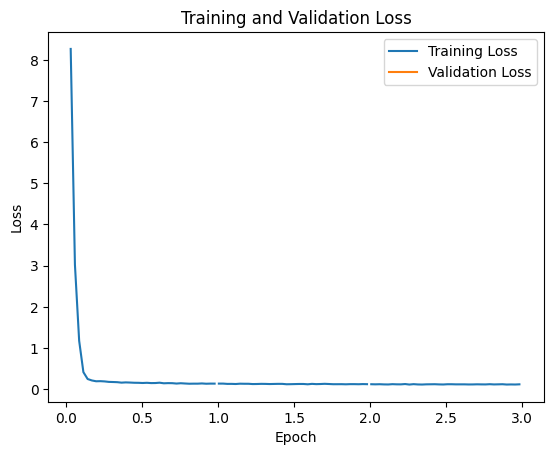

In [31]:
## Optional: Plotting the stats as well
import matplotlib.pyplot as plt

if "train/epoch" in history and "train/loss" in history:
    plt.plot(history['train/epoch'], history['train/loss'], label='Training Loss')
    if "eval/loss" in history:
        plt.plot(history['train/epoch'], history['eval/loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("Epoch or loss data is missing in the history.")

In [25]:
trainer.save_model("./chatbot_finetuned2")
tokenizer.save_pretrained("./chatbot_finetuned2")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('./chatbot_finetuned2/tokenizer_config.json',
 './chatbot_finetuned2/special_tokens_map.json',
 './chatbot_finetuned2/vocab.json',
 './chatbot_finetuned2/merges.txt',
 './chatbot_finetuned2/added_tokens.json')

In [23]:
!zip -r compressed_chatbot_finetuned.zip /kaggle/working/chatbot_finetuned2

  adding: kaggle/working/chatbot_finetuned2/ (stored 0%)
  adding: kaggle/working/chatbot_finetuned2/merges.txt (deflated 53%)
  adding: kaggle/working/chatbot_finetuned2/model.safetensors (deflated 7%)
  adding: kaggle/working/chatbot_finetuned2/tokenizer_config.json (deflated 76%)
  adding: kaggle/working/chatbot_finetuned2/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/chatbot_finetuned2/config.json (deflated 64%)
  adding: kaggle/working/chatbot_finetuned2/training_args.bin (deflated 51%)
  adding: kaggle/working/chatbot_finetuned2/generation_config.json (deflated 47%)
  adding: kaggle/working/chatbot_finetuned2/vocab.json (deflated 68%)
